# Parent Document Retriever
    - When chunk size is large the embedding won't be specific 
    - As much as we could, we should try to make the chunk size as small as possible
    - but the problem is if we reduce the chunk size (context length) the information will be lost
    - because of this reason we introduce parent document retriever

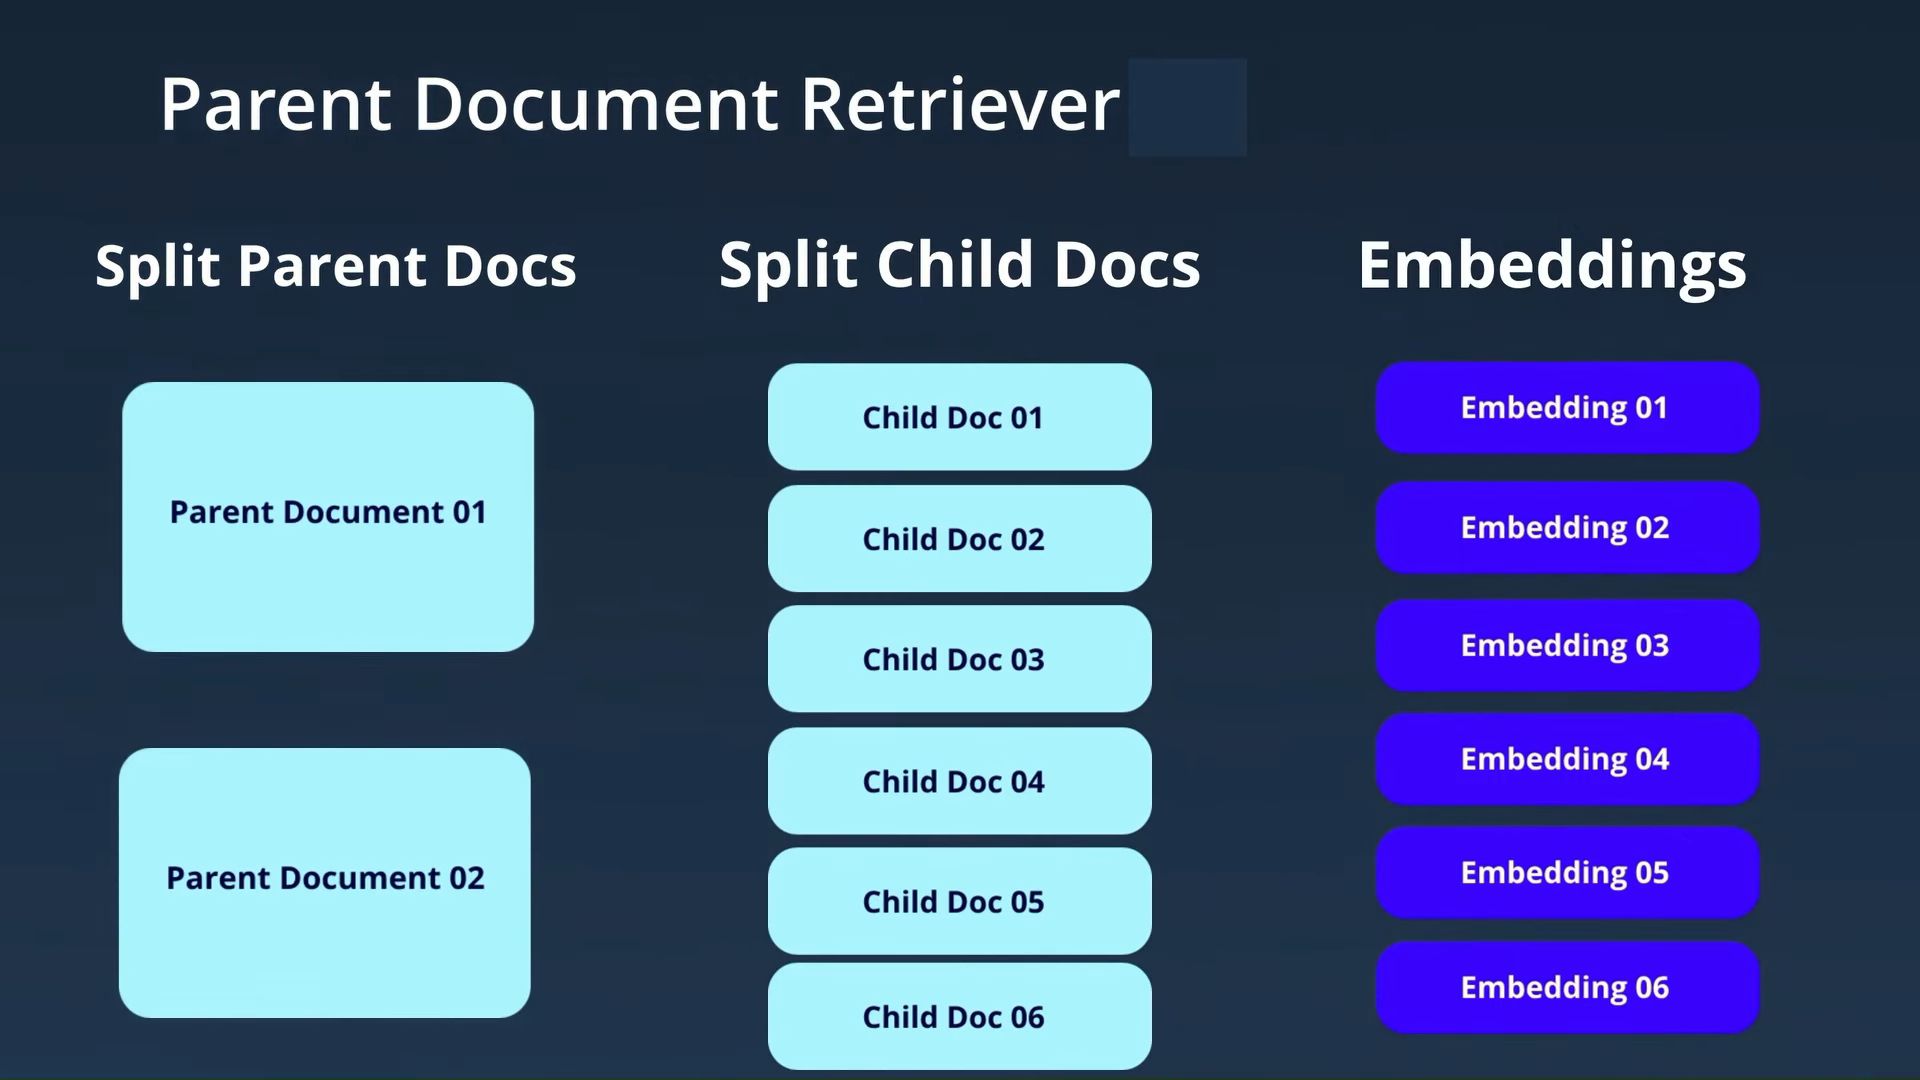

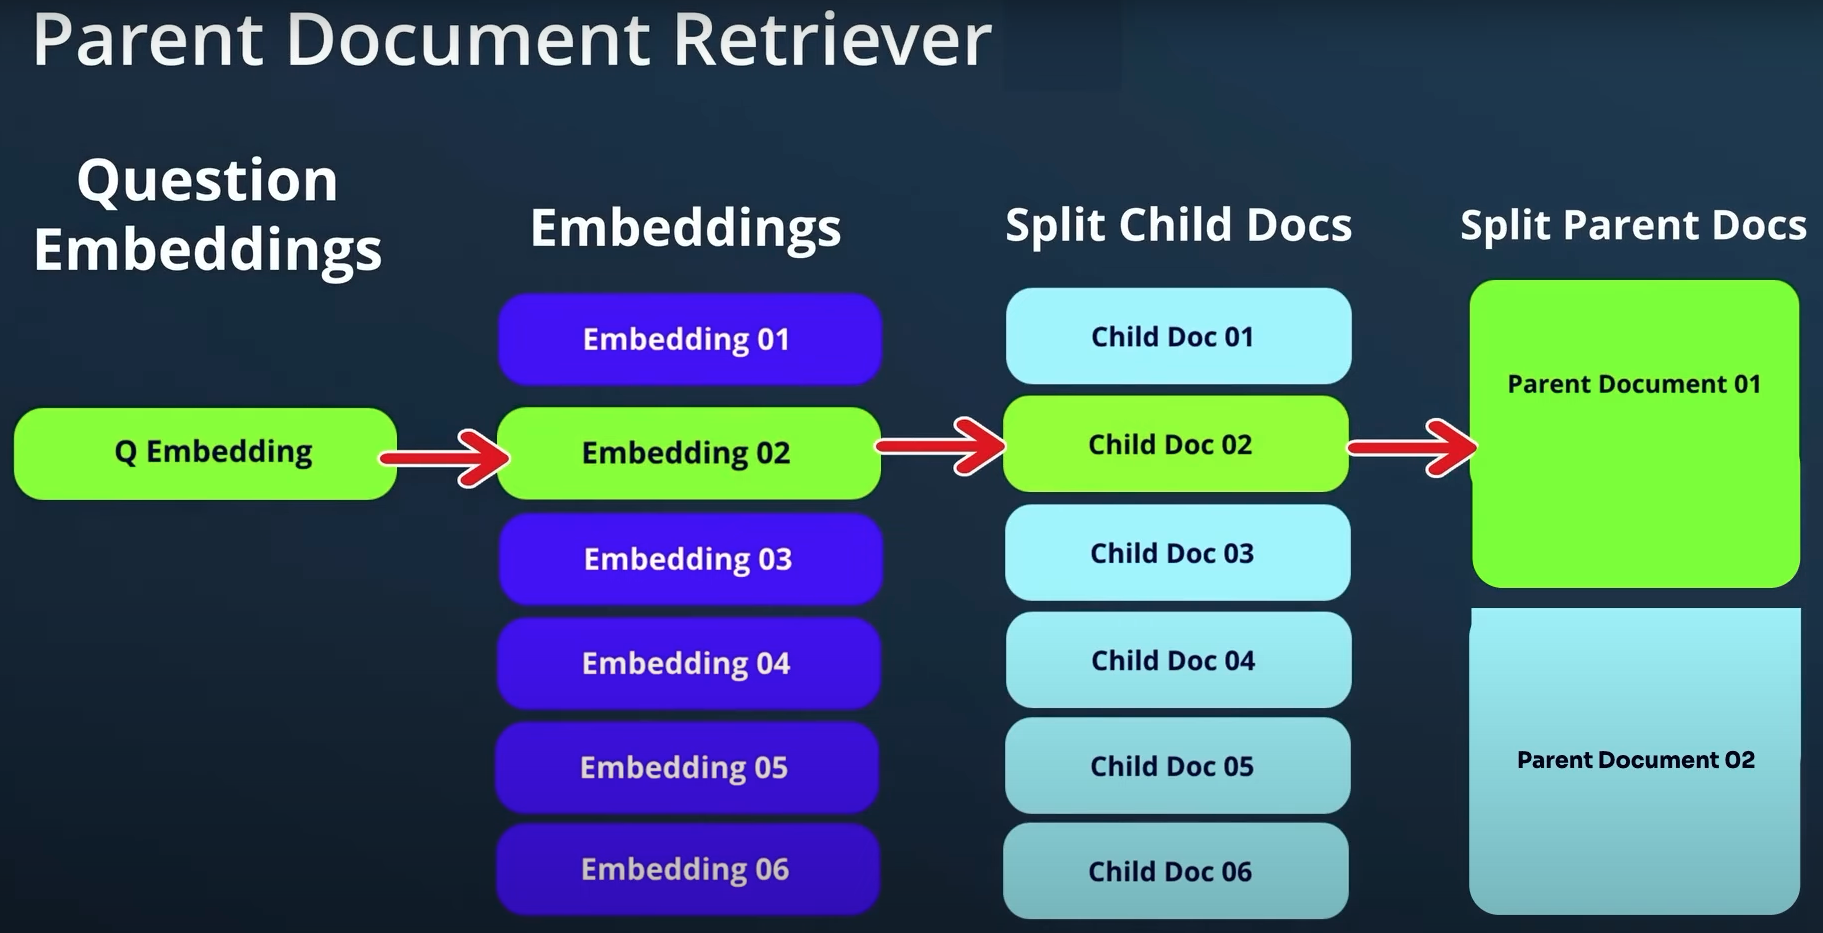

# Process
    1. we devide parent document into parent documents
    2. then we devide parent documents into child documents
    3. generate embeddings for child documents
    4. do the retrieval
    5. in the inference, instead of child documents we use parent documents as the context

2 ways to use it:

    1. Return full docs from smaller chunks look up
    2. Return bigger chunks for smaller chunks look up

In [1]:
!pip -q install -U FlagEmbedding

In [2]:
import yaml, os, openai, textwrap
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from InstructorEmbedding import INSTRUCTOR
from langchain.storage import InMemoryStore
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.retrievers import ParentDocumentRetriever
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [3]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ['ENGINE'] = credentials['ENGINE']

openai.api_key = credentials['OPENAI_API_KEY']
openai.api_base = credentials['OPENAI_API_BASE']
openai.api_type = credentials['OPENAI_API_TYPE']
openai.api_version = credentials['OPENAI_API_VERSION']
openai.engine = credentials['ENGINE']

In [4]:
model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bge_embeddings = HuggingFaceBgeEmbeddings(
                                        model_name=model_name,
                                        model_kwargs={'device': 'mps'},
                                        encode_kwargs=encode_kwargs
                                        )

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [5]:
loaders = [
    TextLoader('data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'),
    TextLoader('data/langchain_blog_posts/blog.langchain.dev_benchmarking-question-answering-over-csv-data_.txt'),
]
docs = []
for l in loaders:
    docs.extend(l.load())

len(docs)

2

In [6]:
docs[0]

Document(page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.\n\nWe started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.\n\nThe blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main is

# 1. Retrieving full documents rather than chunks
        * In this mode, we want to retrieve the full documents.
        * This is good to use if you initial full docs aren't too big themselves and you aren't going to return many of them

In [7]:
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)


# The vectorstore to use to index the child chunks
vectorstore = Chroma(
                    collection_name="full_documents",
                    embedding_function=bge_embeddings  #OpenAIEmbeddings()
                    )

# The storage layer for the parent documents
store = InMemoryStore()

full_doc_retriever = ParentDocumentRetriever(
                                            vectorstore=vectorstore,
                                            docstore=store,
                                            child_splitter=child_splitter,
                                            )

In [8]:
full_doc_retriever.add_documents(docs, ids=None)

In [9]:
# in the store it should only be 2 docs
list(store.yield_keys())

['dc0620e3-8d1a-4fb7-b6ed-cda3539acb5e',
 'e9ecf3b9-b693-482a-a715-f12a3d3fb493']

In [10]:
sub_docs = vectorstore.similarity_search("what is langsmith", k=2)
sub_docs

[Document(page_content='Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.', metadata={'doc_id': 'dc0620e3-8d1a-4fb7-b6ed-cda3539acb5e', 'source': 'data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'}),
 Document(page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.', metadata={'doc_id': 'dc0620e3-8d1a-4fb7-b6ed-cda3539acb5e', 'source': 'data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'})]

In [11]:
retrieved_docs = full_doc_retriever.get_relevant_documents("what is langsmith")
retrieved_docs

[Document(page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.\n\nWe started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.\n\nThe blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main i

In [12]:
child_chunk = sub_docs[0].page_content
parent_doc = retrieved_docs[0].page_content # in this case parent_doc == full_doc

In [13]:
print("Length of child chunk: ", len(child_chunk))
print("Length of parent doc: ", len(parent_doc))

Length of child chunk:  229
Length of parent doc:  11652


# 2. Retrieving larger chunks

In [14]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
                    collection_name="split_parents", 
                    embedding_function=bge_embeddings
                    ) #OpenAIEmbeddings()

# The storage layer for the parent documents
store = InMemoryStore()

In [15]:
big_chunks_retriever = ParentDocumentRetriever(
                                            vectorstore=vectorstore,
                                            docstore=store,
                                            child_splitter=child_splitter,
                                            parent_splitter=parent_splitter,
                                            )

In [16]:
big_chunks_retriever.add_documents(docs)
len(list(store.yield_keys())) # the reason is the parent doc not any more the full doc but being splitted to 2000 chars

18

In [17]:
sub_docs = vectorstore.similarity_search("what is langsmith")
sub_docs

[Document(page_content='Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.', metadata={'doc_id': '9dec11a8-7bba-43ac-ba07-66ad8a4966b3', 'source': 'data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'}),
 Document(page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.', metadata={'doc_id': '9dec11a8-7bba-43ac-ba07-66ad8a4966b3', 'source': 'data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'}),
 Document(page_content='LangSmith is now in closed beta. So if you’re looking for a robust, unified, system for debugging, testing, evaluating, and monitoring you

In [18]:
retrieved_docs = big_chunks_retriever.get_relevant_documents("what is langsmith")
retrieved_docs

[Document(page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.\n\nWe started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.\n\nThe blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main i

In [19]:
child_chunk = sub_docs[0].page_content
parent_doc = retrieved_docs[0].page_content

In [20]:
print("Length of child chunk: ", len(child_chunk))
print("Length of parent doc: ", len(parent_doc))

Length of child chunk:  229
Length of parent doc:  1869


# Make the Chain

In [21]:
llm = ChatOpenAI(
                openai_api_key=os.environ["OPENAI_API_KEY"],
                engine = os.environ["ENGINE"],
                model='gpt-3.5-turbo',
                temperature=0.9, 
                max_tokens = 256
                )

WARNING! engine is not default parameter.
                    engine was transferred to model_kwargs.
                    Please confirm that engine is what you intended.


In [22]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=big_chunks_retriever)

In [23]:
query = "What is Langsmith?"
qa.run(query)

'LangSmith is a unified platform designed to help developers close the gap between prototype and production when building applications powered by LLMs (Large Language Models). It provides tools for debugging, testing, evaluating, and monitoring LLM applications. LangSmith aims to address the challenges of application performance and complexity that arise when taking an LLM-powered application from prototype to production. It offers features such as analyzing LLM calls, understanding performance, debugging errors, improving prompt engineering, and creating datasets for testing and evaluation. Currently in closed beta, LangSmith aims to provide a robust and fully-integrated hub for managing LLM applications.'